In [1]:
import sys
sys.path.insert(0, "..")
from utils.dataset_utils import OriginalDataset, plot_image_array, plot_delta

# Standard Downloads
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
original_dataset = OriginalDataset('../datasets/droid_100_sample_pictures')
len_ = (original_dataset.__len__())
print(len_)

166


In [3]:
image1 = original_dataset[0]
image1 = np.array(image1, dtype = np.int16)
image1.shape

# image2 = original_dataset[0]
# image2 = np.array(image1, dtype = np.int16)
# image2.shape


(180, 320, 3)

In [34]:
block_size = 4
M = image1.shape[0]//block_size
N = image1.shape[1]//block_size

M,N

(45, 80)

In [35]:
macroblock1 = [image1[x:x+M,y:y+N] for x in range(0,image1.shape[0],M) for y in range(0,image1.shape[1],N)]

In [ ]:
def create_macroblocks(image, block_size=16):
    """
    Divide an image into macroblocks of size block_size x block_size.
    
    Args:
        image (numpy.ndarray): Input image of shape (height, width, channels).
        block_size (int): Size of each macroblock (default is 16x16).
    
    Returns:
        macroblocks (list): List of macroblocks.
    """
    height, width, channels = image.shape
    padded_height = ((height + block_size - 1) // block_size) * block_size
    padded_width = ((width + block_size - 1) // block_size) * block_size
    
    # Pad the image to make it divisible by block_size
    padded_image = np.zeros((padded_height, padded_width, channels), dtype=image.dtype)
    padded_image[:height, :width, :] = image
    
    # Create macroblocks
    macroblocks = []
    for y in range(0, padded_height, block_size):
        for x in range(0, padded_width, block_size):
            block = padded_image[y:y+block_size, x:x+block_size, :]
            macroblocks.append(block)
    
    return macroblocks

# Example usage
# image = np.random.randint(0, 256, (180, 320, 3), dtype=np.uint8)  # Random 180x320 RGB image
macroblocks = create_macroblocks(image1)

print(f"Number of macroblocks: {len(macroblocks)}")
print(f"Shape of each macroblock: {macroblocks[0].shape}")


Number of macroblocks: 240
Shape of each macroblock: (16, 16, 3)


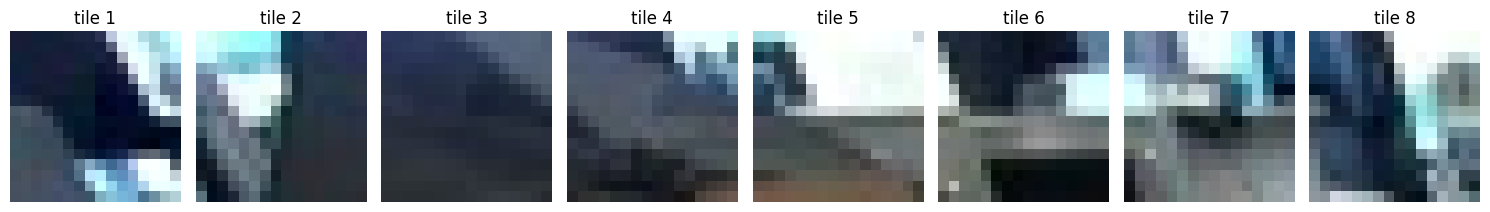

In [30]:
fig, axes = plt.subplots(1, block_size, figsize=(15, 5))

for i in range (block_size):
    axes[i].imshow(macroblocks[i])
    axes[i].set_title(f'tile {i+1}')
    axes[i].axis('off')  # Turn off axis labels

# Show the plot
plt.tight_layout()
plt.show()

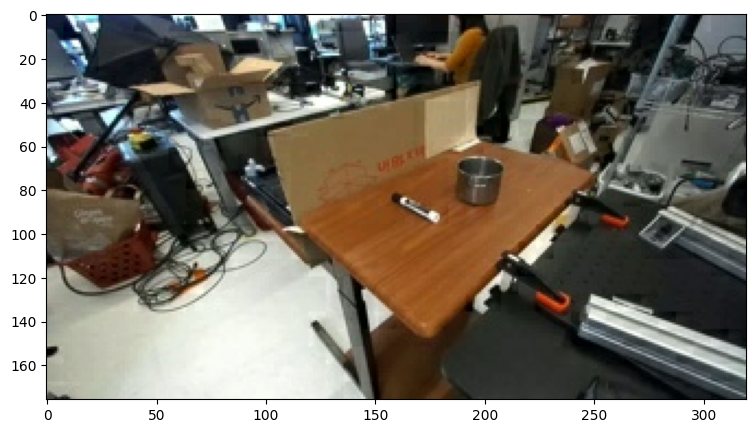

In [36]:
def recreate_image(tiles, original_shape, tile_size):
    # Create a blank image with the original shape
    reconstructed_image = np.zeros(original_shape, dtype=tiles[0].dtype)
    
    # Get the dimensions of each tile
    M, N = tile_size
    
    # Paste each tile back into the reconstructed image
    index = 0
    for x in range(0, original_shape[0], M):
        for y in range(0, original_shape[1], N):
            # Place the tile at the correct location
            reconstructed_image[x:x+M, y:y+N] = tiles[index]
            index += 1
    
    return reconstructed_image

# Example usage
# Assume tiles1 is your list of tiles, each tile has a size (M, N), and you know the original shape of the image
M, N = macroblocks[0].shape[0], macroblocks[0].shape[1]  # Size of each tile
original_shape = (M * (image1.shape[0] // M), N * (image1.shape[1] // N), image1.shape[2])  # Calculate original shape

# Recreate the image from the tiles
recreated_image = recreate_image(macroblocks, original_shape, (M, N))

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
plt.imshow(recreated_image)


plt.show()

In [38]:
diff = image1 - recreated_image

ValueError: operands could not be broadcast together with shapes (180,320,3) (176,320,3) 

Testing some chat gpt code 

In [39]:
import numpy as np

def divide_into_macroblocks(image, block_size=16):
    """
    Divide an image into macroblocks of block_size x block_size.
    
    Args:
        image (numpy.ndarray): Input image of shape (height, width, channels).
        block_size (int): Size of each macroblock.
    
    Returns:
        macroblocks (list): List of macroblocks.
        padded_image (numpy.ndarray): Padded version of the input image.
    """
    height, width, channels = image.shape
    padded_height = ((height + block_size - 1) // block_size) * block_size
    padded_width = ((width + block_size - 1) // block_size) * block_size
    
    # Pad the image with zeros if needed
    padded_image = np.zeros((padded_height, padded_width, channels), dtype=image.dtype)
    padded_image[:height, :width, :] = image

    # Extract macroblocks
    macroblocks = []
    for y in range(0, padded_height, block_size):
        for x in range(0, padded_width, block_size):
            macroblock = padded_image[y:y+block_size, x:x+block_size, :]
            macroblocks.append(macroblock)
    
    return macroblocks, padded_image

def reconstruct_from_macroblocks(macroblocks, original_shape, block_size=16):
    """
    Reconstruct the image from macroblocks.
    
    Args:
        macroblocks (list): List of macroblocks.
        original_shape (tuple): Shape of the original image (height, width, channels).
        block_size (int): Size of each macroblock.
    
    Returns:
        reconstructed_image (numpy.ndarray): Reconstructed image with original dimensions.
    """
    padded_height = ((original_shape[0] + block_size - 1) // block_size) * block_size
    padded_width = ((original_shape[1] + block_size - 1) // block_size) * block_size
    
    # Reconstruct the padded image
    reconstructed_image = np.zeros((padded_height, padded_width, original_shape[2]), dtype=macroblocks[0].dtype)
    macroblock_index = 0
    for y in range(0, padded_height, block_size):
        for x in range(0, padded_width, block_size):
            reconstructed_image[y:y+block_size, x:x+block_size, :] = macroblocks[macroblock_index]
            macroblock_index += 1
    
    # Crop to original shape
    reconstructed_image = reconstructed_image[:original_shape[0], :original_shape[1], :]
    return reconstructed_image

# Example Usage
original_image = image1 # Random 320x180 RGB image
macroblocks, padded_image = divide_into_macroblocks(original_image)
reconstructed_image = reconstruct_from_macroblocks(macroblocks, original_image.shape)

# Validate pixel-to-pixel equality
if np.array_equal(original_image, reconstructed_image):
    print("Reconstruction successful! The images are identical.")
else:
    print("Reconstruction failed. The images differ.")


Reconstruction successful! The images are identical.
